In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt


import tensorflow as tf 
from tensorflow import keras

from tqdm.notebook import tqdm
import time as tm


# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.run_functions_eagerly(False)


MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rcdefaults()

# plt.rc('font',**{'family':'serif','serif':['Times']})
# plt.rc('text', usetex=True)

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


%matplotlib inline

2024-12-21 21:45:51.541317: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 21:45:51.544250: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 21:45:51.553834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-21 21:45:51.568682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-21 21:45:51.573097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 21:45:51.584052: I tensorflow/core/platform/cpu_feature_gu

### Generate data for a one-parameter line $y=kx$

In [2]:
from models import LocalOptimizer, GlobalOptimizer
from optimizeme import LinearFunction, SlopeInitializer
from data_generators import LinearGenerator
from config import Params

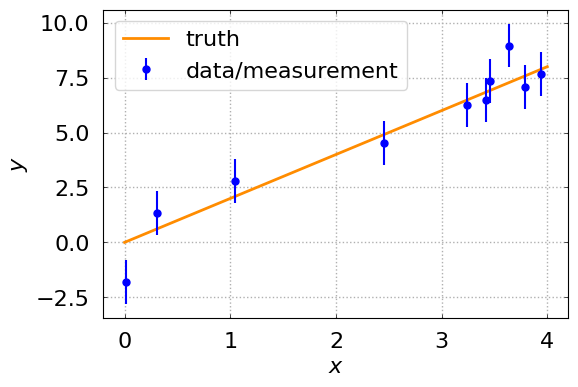

In [3]:
# generate data 

rng = np.random.default_rng(seed=13)   # a random seed to have the same data every time we run this code cell

k0 = 2  # a "true" value for k
x_upper = 4

n_pts = 10
sigma = 1   # sigma for a Gaussian noise

x_data = x_upper*rng.random(n_pts)   # x values for the "measurement"
y_true = LinearGenerator.f1(x_data,k0)   # true y values
noise = sigma*rng.normal(scale=sigma, size=n_pts)
y_data = y_true + noise   # the data = true values + the noise
xx = np.linspace(0,4,500)
yy = LinearGenerator.f1(xx, k0)

# let us record the data for future use below

data_one_par = [x_data.copy(), y_data.copy(), k0, sigma]

fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(6,4))

ax.plot(xx,yy, c='darkorange', lw=2, label='truth')
ax.errorbar(x_data,y_data, yerr=sigma, fmt='b.', ms=10, label='data/measurement')

ax.grid(True,linestyle=':',linewidth='1.')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params('both',length=3,width=0.5,which='both',direction = 'in',pad=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.legend()

### Find $k$ by minimizing the deviations

We are to minimize

$$
\chi^2\equiv\frac 1N\sum\limits_{i=1}^N\left[y_i - k x_i\right]^2\,,
$$
with its gradient w.r.t. being

$$
\frac{\partial\chi^2}{\partial k} = -\frac 2N\sum\limits_{i=1}^N x_i\left[y_i - k x_i\right] = 0 \qquad \Rightarrow \qquad k = \frac{\sum y_i x_i}{\sum x_i^2}\,.
$$

In [4]:
k_opt = np.sum(y_data*x_data)/np.sum(x_data**2)

print('Optimal value of k: {:.5f}'.format(k_opt))

Optimal value of k: 2.03409


In [5]:
## Sanity check using a built-in scipy function

from scipy.optimize import curve_fit

coefs,pcov = curve_fit(LinearGenerator.f1, x_data, y_data)   # pcov 

# sigmas = np.full_like(y_data, sigma)
# coefs,pcov = curve_fit(f, x_data, y_data, sigma=sigmas)
k_sp = coefs[0]

print('Scipy value of k: {:.5f}'.format(k_sp))

Scipy value of k: 2.03409


In [6]:
## Vanilla gradient decent

num_iters = 30
lr = 0.01
k_calc = -5 + 10*rng.random()

with tqdm(range(num_iters)) as tepoch:
    for i in tepoch:

        tepoch.set_description(f"Iteration {i+1}/{num_iters}")
        k_calc += lr*np.sum(x_data*(y_data - k_calc*x_data))
        tepoch.set_postfix_str("k={:.4f}".format(k_calc))
        tm.sleep(0.05)

print('GD after {:d} iterations value of k: {:.5f}'.format(num_iters, k_sp))

  0%|          | 0/30 [00:00<?, ?it/s]

GD after 30 iterations value of k: 2.03409


### Compare a neural network (LSTM) optimizer with conventional optimizers

In [17]:
test_steps = 30
num_test_batches = 4

## define an initializer and an optimizee

initializer = SlopeInitializer(eps=Params.eps)
optimizee = LinearFunction(
    initializer=initializer
)

## load a trained GlobalOptimizer model

model = GlobalOptimizer(
    optimizee=optimizee
)

_ = model(
    keras.Input(shape=(Params.NUM_PTS, 2))
)

model.load_weights('./linear_model.weights.h5')

## initialize a data generator for test data

test_generator = LinearGenerator(initializer, Params.BATCH_SIZE, Params.STEPS_PER_EPOCH)

In [18]:
data_original = tf.concat((x_data[...,np.newaxis], y_data[...,np.newaxis]), axis=-1)
data_original = tf.cast(data_original[tf.newaxis,...], dtype=tf.float32)

_,var_pred = model(data_original, training=False, num_iters=test_steps)

print('LSTM optimizer after {:d} iterations value of k: {:.5f}'.format(test_steps, var_pred.numpy().flatten()[0]))

LSTM optimizer after 30 iterations value of k: 2.03397


In [19]:

# compute LSTM losses on test batches and record the same batches to test the LocalOptimizer

losses = []
params_test = []

for idx,batch in enumerate(test_generator):
    if idx == num_test_batches:
        break
    loss_on_batch,_ = model(batch, training=False, num_iters=test_steps)
    losses.append(loss_on_batch)
    params_test.append(batch)

losses = tf.concat(losses, axis=0).numpy()
params_test = tf.concat(params_test, axis=0)



test_losses = {}


optimizers = ['nag','adam', 'rmsprop', 'sgd']
lrates = np.logspace(-0.5,-2, 10)

for optimizer in optimizers:
    
    print(f'Optimizer: {optimizer}\n')

    trial_loss = []

    for lr in lrates:

        if optimizer == 'nag':
            model_optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.6, nesterov=True)
        else:
            model_optimizer = keras.optimizers.get(optimizer).from_config({'learning_rate':lr})

        trial_loss.append(
            LocalOptimizer(
                optimizee, model_optimizer, params_test, test_steps
            ).numpy()
        )
    trial_median = np.percentile(trial_loss, q=50, axis=1)
    best_idx = np.argmin(trial_median[:,-1,0]) 
    print(best_idx)

    test_losses[optimizer] = trial_loss[best_idx]



Optimizer: nag

4
Optimizer: adam

0
Optimizer: rmsprop

1
Optimizer: sgd

3


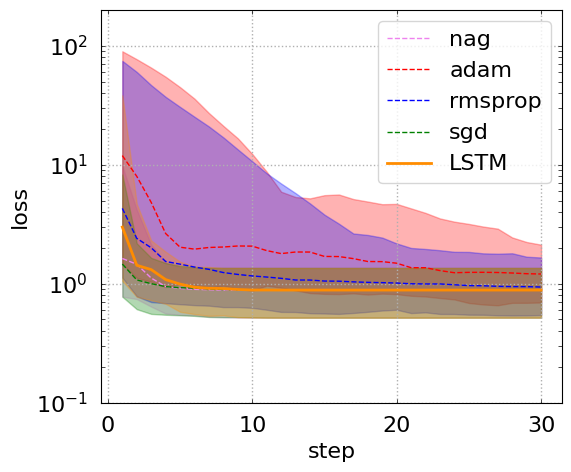

In [20]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(6,5))

for optimizer,color in zip(optimizers,['violet','red','blue','green']):
    
    low,median,high = np.percentile(test_losses[optimizer], q=[16,50,84], axis=0)
    
    xx = 1 + np.arange(low.shape[0])
    ax.semilogy(xx, median.flatten(), color=color, lw=1, ls='dashed',label=optimizer)
    ax.fill_between(xx, low.flatten(), high.flatten(), color=color, alpha=0.3)

low,median,high = np.percentile(losses, q=[16,50,84], axis=0)

xx = 1 + np.arange(low.shape[0])
ax.semilogy(xx, median.flatten(), color='darkorange', lw=2, label='LSTM')
ax.fill_between(xx, low.flatten(), high.flatten(), color='darkorange', alpha=0.3)

ax.legend(loc='upper right')
ax.grid(True,linestyle=':',linewidth='1.')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.tick_params('both',length=3,width=0.5,which='both',direction = 'in',pad=10)

ax.set_ylim(1e-1, 2e+2)

ax.set_xlabel('step')
ax.set_ylabel('loss')

fig.tight_layout()
#fig.savefig('linear_optimizees.png')